# Visual Search

**Pre-requisite**:
- MXNet: `pip install --pre mxnet-cu91`
- hnswlib (follow the guide here: https://github.com/nmslib/hnsw)

In [1]:
import mxnet as mx
from mxnet import gluon, nd
from mxnet.gluon.model_zoo import vision
import multiprocessing
from mxnet.gluon.data.vision.datasets import ImageFolderDataset
from mxnet.gluon.data import DataLoader
import numpy as np
import wget
import imghdr
import json
import pickle
import hnswlib
import numpy as np
import glob, os, time
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import urllib.parse
import urllib
import gzip
import os
import tempfile
import glob
from os.path import join
%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


ModuleNotFoundError: No module named 'hnswlib'

Data originally from here:
http://jmcauley.ucsd.edu/data/amazon/

*Image-based recommendations on styles and substitutes
J. McAuley, C. Targett, J. Shi, A. van den Hengel
SIGIR, 2015*

## Downloading images
We only use a subset of the total number of images, here 1M
(it takes about 40 minutes to download all the data on an ec2 instance)

In [3]:
subset_num = 1000000

Beware, if using the full dataset this will download **300GB** of images, make sure you have the appropriate hardware and connexion!
Alternatively, just set `images_path` to a directory containing images following this format `ID.jpg`

In [27]:
data_path = 'metadata.json'
images_path = join('/data','amazon_images_subset')

Download the metadata.json file that contains the URL of the images

In [7]:
if not os.path.isfile(data_path):
    # Downloading the metadata, 3.1GB, unzipped 9GB
    !wget -nv https://s3.us-east-2.amazonaws.com/mxnet-public/stanford_amazon/metadata.json.gz
    !gzip -d metadata.json.gz

if not os.path.isdir(images_path):
    os.makedirs(images_path)

In [6]:
num_lines = 0
num_lines = sum(1 for line in open(data_path))
assert num_lines >= subset_num, "Subset needs to be smaller or equal to total number of example"

In [ ]:
def parse(path, num_cpu, modulo):
    g = open(path, 'r')
    for i, l in enumerate(g):
        if (i >= num_lines - subset_num and i%num_cpu == modulo):
            yield eval(l)

In [ ]:
def download_files(modulo):
    for i, data in enumerate(parse(data_path, NUM_CPU, modulo)):
        if (i%1000000==0):
            print(i)
        if 'imUrl' in data and data['imUrl'] is not None and 'categories' in data and data['imUrl'].split('.')[-1] == 'jpg':
            url = data['imUrl']
            try:
                path = os.path.join(images_path, data['asin']+'.jpg')
                if not os.path.isfile(path):
                    file = urllib.request.urlretrieve(url, path)
            except:
                print("Error downloading {}".format(url))

In [8]:
NUM_CPU = multiprocessing.cpu_count()*10

In [ ]:
pool = multiprocessing.Pool(processes=NUM_CPU)
results = pool.map(download_files, list(range(NUM_CPU)))

In [ ]:

list_files = glob.glob(os.path.join(images_path, '**.jpg'))
for file in list_files:
    if imghdr.what(file) != 'jpeg':
        print('Removed {} it is a {}'.format(file, imghdr.what(file)))
        os.remove(file)

## 生成图片特征

In [21]:
BATCH_SIZE = 256
EMBEDDING_SIZE = 512
SIZE = (224, 224)
MEAN_IMAGE= mx.nd.array([0.485, 0.456, 0.406])
STD_IMAGE = mx.nd.array([0.229, 0.224, 0.225])

### 模型加载


In [22]:
ctx = mx.gpu() if len(mx.test_utils.list_gpus()) else mx.cpu()

Networks from the model-zoo follow the convention that the features are on the `.features` property and output on the `.output` property. It makes it very easy to transform any pre-trained network in featurizer.

In [278]:
net = vision.resnet18_v2(pretrained=True, ctx=ctx).features

In [19]:
net.hybridize()

In [20]:
net(mx.nd.ones((1,3,224,224), ctx=ctx))
net.export(join('mms','visualsearch'))

### 数据转换


In [24]:
def transform(image, label):
    resized = mx.image.resize_short(image, SIZE[0]).astype('float32')
    cropped, crop_info = mx.image.center_crop(resized, SIZE)
    cropped /= 255.
    normalized = mx.image.color_normalize(cropped,
                                      mean=MEAN_IMAGE,
                                      std=STD_IMAGE) 
    transposed = nd.transpose(normalized, (2,0,1))
    return transposed, label

### 数据读取

In [122]:
empty_folder = tempfile.mkdtemp()
# Create an empty image Folder Data Set
dataset = ImageFolderDataset(root=empty_folder, transform=transform)

In [123]:
list_files = glob.glob(os.path.join(images_path, '**.jpg'))

In [124]:
print("[{}] images".format(len(list_files)))

[959440] images


#### 保存二进制文件

In [60]:
pickle.dump(idx_ASIN, open(idx_asin_file, 'wb'), protocol=2)
pickle.dump(ASIN_data, open(ASIN_data_file, 'wb'), protocol=2)

In [62]:
# We map the files to the dataset

In [125]:
dataset.items = list(zip(list_files, [0]*len(list_files)))

In [64]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, last_batch='keep', shuffle=False, num_workers=multiprocessing.cpu_count())

### 创建图片特征和目录的对应

In [65]:
features = np.zeros((len(dataset), EMBEDDING_SIZE), dtype=np.float32)

## 创建对应的index

In [67]:
# Number of elements in the index
num_elements = len(features)
labels_index = np.arange(num_elements)

In [34]:
# Declaring index
p = hnswlib.Index(space = 'cosine', dim = EMBEDDING_SIZE) # possible options are l2, cosine or ip

In [1]:
%%time 
# Initing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = num_elements, ef_construction = 100, M = 16)

# Element insertion (can be called several times):
int_labels = p.add_items(features, labels_index)

NameError: name 'p' is not defined

In [90]:
# Controlling the recall by setting ef:
p.set_ef(300) # ef should always be > k

In [72]:
p.save_index(join('mms', 'index.idx'))

In [35]:
p.load_index(join('mms','index.idx'))

### 加载最近邻算法测试

We test the results by sampling random images from the dataset and searching their K-NN

In [36]:
def plot_predictions(images):
    gs = gridspec.GridSpec(3, 3)
    fig = plt.figure(figsize=(15, 15))
    gs.update(hspace=0.1, wspace=0.1)
    for i, (gg, image) in enumerate(zip(gs, images)):
        gg2 = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gg)
        ax = fig.add_subplot(gg2[:,:])
        ax.imshow(image, cmap='Greys_r')
        ax.tick_params(axis='both',       
                       which='both',      
                       bottom='off',      
                       top='off',         
                       left='off',
                       right='off',
                       labelleft='off',
                       labelbottom='off') 
        ax.axes.set_title("result [{}]".format(i))
        if i == 0:
            plt.setp(ax.spines.values(), color='red')
            ax.axes.set_title("SEARCH".format(i))

In [37]:
def search(N, k):
    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    q_labels, q_distances = p.knn_query([features[N]], k = k+1)
    images = [plt.imread(dataset.items[label][0]) for label in q_labels[0][1:]]
    plot_predictions(images)

## 使用目标检测和图像分割提升模型准确度

In [477]:
import mxnet as mx
import numpy as np
import gluoncv as gcv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from mxnet import nd, image
from mxnet.gluon.data.vision import transforms
from gluoncv.model_zoo import get_model
from gluoncv.utils import viz, download

### 使用一张图片进行测试

In [515]:
path = 'lady-clothes.jpg'

In [516]:
x, img = gcv.data.transforms.presets.ssd.load_test(path, short=512)

In [2]:
viz.plot_image(img)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

NameError: name 'viz' is not defined

In [8]:
image = plt.imread(path)[:,:,:3]
image_t, _ = transform(nd.array(image), 1)
output = net(image_t.expand_dims(axis=0).as_in_context(ctx))
labels, distances = p.knn_query([output.asnumpy().reshape(-1,)], k = 6)
images = [image]
images += [plt.imread(dataset.items[label][0]) for label in labels[0][1:]]

NameError: name 'plt' is not defined

In [3]:
plot_predictions(images)

NameError: name 'plot_predictions' is not defined

## 目标检测

In [4]:
ssdnet =  get_model('ssd_512_resnet50_v1_coco', pretrained=True, ctx=ctx)

NameError: name 'get_model' is not defined

In [5]:
classes, scores, bbox = ssdnet(x.as_in_context(ctx))

NameError: name 'ssdnet' is not defined

In [6]:
viz.plot_bbox(img, bbox[0], scores[0], classes[0], class_names=ssdnet.classes)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

NameError: name 'viz' is not defined

In [7]:
bbout = None
for i, (c, s, bb) in enumerate(zip(classes[0].asnumpy(), scores[0].asnumpy(), bbox[0].asnumpy())):
    if c == 0 and s > 0.5:
        bbout = bb
        break
assert bbout is not None

NameError: name 'classes' is not defined

## 在图片中圈出方框

In [524]:
diff_x = int(max((bbout[3]-bbout[1])-(bbout[2]-bbout[0]), 0)/2)
diff_y = int(max(-(bbout[3]-bbout[1])+(bbout[2]-bbout[0]), 0)/2)
x0 = max(int(bbout[0])-diff_x, 0)
x1 = min(int(bbout[2])+diff_x, img.shape[1])
y0 = max(int(bbout[1])-diff_y, 0)
y1 = min(int(bbout[3])+diff_y, img.shape[0])
cropped_img = img[y0:y1, x0:x1, :]

In [525]:
img.shape

(512, 906, 3)

In [9]:
image_t, _ = transform(nd.array(cropped_img), 1)
output = net(image_t.expand_dims(axis=0).as_in_context(ctx))
labels, distances = p.knn_query([output.asnumpy().reshape(-1,)], k = 6)
images = [cropped_img]
images += [plt.imread(dataset.items[label][0]) for label in labels[0][1:]]
plot_predictions(images)

NameError: name 'transform' is not defined

## 图像分割

In [528]:
pspnet = get_model('FCN_resnet50_ade', pretrained=True, ctx=ctx)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/mxnet/gluon/block.py:415: UserWarning: load_params is deprecated. Please use load_parameters.
  warnings.warn("load_params is deprecated. Please use load_parameters.")


In [529]:
from PIL import Image
im = Image.fromarray(cropped_img)
im.save("test.jpg")
x, cropped_loaded = gcv.data.transforms.presets.ssd.load_test('test.jpg', min(cropped_img.shape[1], cropped_img.shape[0]))

In [530]:
output = pspnet.demo(x.as_in_context(ctx))
pred = output.argmax(1).asnumpy().squeeze()

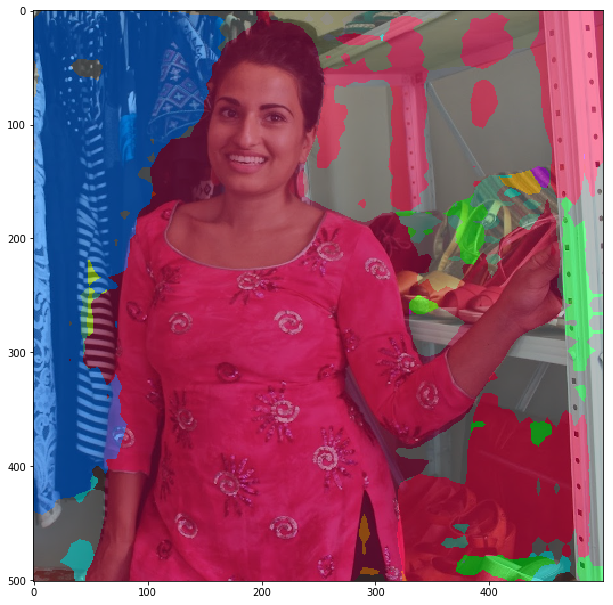

In [531]:
mask = viz.get_color_pallete(pred, 'ade20k')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+cropped_img)/2

plt.imshow(combined.astype(np.uint8))
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## Filtered for humans

In [532]:
HUMAN = 12
filtered = (pred == HUMAN)
filtered = filtered.reshape(*filtered.shape, 1).repeat(3, 2)
filtered_img = filtered*cropped_img
filtered_img[filtered==False] = 255

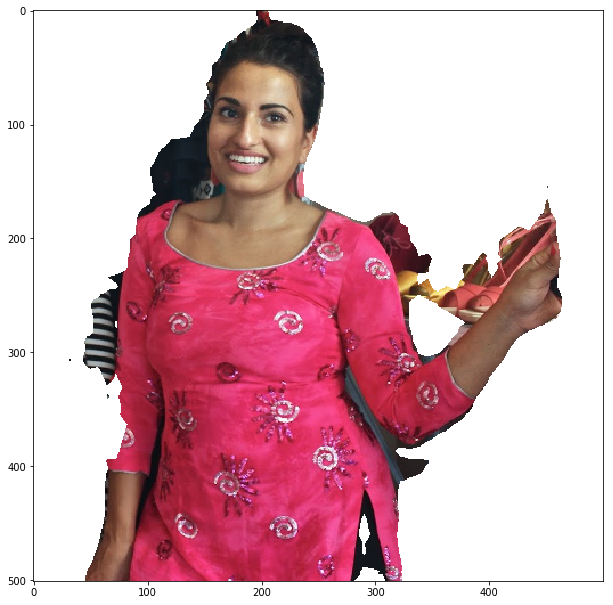

In [533]:
viz.plot_image(filtered_img)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [10]:
image_t, _ = transform(nd.array(filtered_img), 1)
output = net(image_t.expand_dims(axis=0).as_in_context(ctx))
labels, distances = p.knn_query([output.asnumpy().reshape(-1,)], k = 6)
images = [filtered_img]
images += [plt.imread(dataset.items[label][0]) for label in labels[0][1:]]
plot_predictions(images)

NameError: name 'transform' is not defined